In [2]:
import networkx as nx
import pandas as pd
import numpy as np 
%matplotlib inline 
import itertools
import matplotlib.pyplot as plt 
import seaborn as sn 
from scipy.stats import kstest, ks_2samp
import progressbar
import json 
import gc
from shapely.geometry import GeometryCollection, shape
import multiprocessing 
import ctypes
import pickle
from collections import deque 
from copy import deepcopy

In [3]:
print("Loading census data...") 
with open("../data/washington_DC_censustracts.json", 'r') as f: 
    features =  json.load(f)['features']

col = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])

# divide into four equal segments 
all_values = [] 
for i in range(len(col)): 
    for j in range(i + 1, len(col)): 
        all_values.append((i, j))

Loading census data...


In [4]:
processes = 3
chunk_size = len(all_values) // processes + 1
segments = [all_values[chunk_size * i:chunk_size * (i + 1)] for i in range(processes)]
value = multiprocessing.Value(ctypes.c_ulong, lock=False)
lock = multiprocessing.Lock()
queue = multiprocessing.Queue()
args = [(segment, col, value, features) for segment in segments]

In [5]:
def adj_function(segment, col, counter, features): 
    c = 0 
    edge_set = set() 
    for i, j in segment: 
        c += 1
        if c % 10000 == 0: 
            res = lock.acquire(timeout=10) 
            if res: 
                counter.value += c 
                queue.put(tuple(edge_set))
                lock.release() 
                c = 0  
                edge_set = set() 
        if i != j: 
            if col[i].touches(col[j]): 
                t = (features[i]['properties']['MOVEMENT_ID'], features[j]['properties']['MOVEMENT_ID'])
                edge_set.add(t)
                edge_set.add((t[1], t[0]))


In [6]:
print("Calculating Adjacencies...")
ps = []
value.value = 0 
for i in range(processes): 
    ps.append(multiprocessing.Process(target=adj_function, args=args[i]))
    ps[-1].start() 
    

Calculating Adjacencies...


In [7]:
widgets = [
    progressbar.Bar(),
    progressbar.SimpleProgress(),
    "   ",
    progressbar.ETA(), 
    progressbar.Percentage()]
bar = progressbar.ProgressBar(max_value=len(all_values), widgets=widgets)
l = [] 
while all((p.is_alive() for p in ps)):
    bar.update(value.value)
    if not queue.empty(): 
        l.append(queue.get()) 

for p in ps: 
    p.join()

|#################################       |130000 of 155403   ETA:   0:00:00 83%

In [8]:
while not queue.empty(): 
    l.append(queue.get())

In [9]:
all_edges = [] 
for k in l: 
    all_edges += k 
all_edges = set(all_edges)

In [10]:
print("Reading in Uber Data...")
df = pd.read_csv("../data/washington_DC-censustracts-2019-3-OnlyWeekdays-HourlyAggregate.csv", low_memory=False)
print("Filtering...")
RUSH_HOUR_START = 6 
RUSH_HOUR_END = 10 
filtered_df = df[df['hod'] <= RUSH_HOUR_END][df['hod'] >= RUSH_HOUR_START]
del df 
filtered_df = filtered_df.reset_index().drop('index', axis=1)
gc.collect() 
filtered_df.head()

Reading in Uber Data...
Filtering...


/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,403,398,8,167.15,134.52,125.59,2.44
1,156,108,7,540.13,266.69,495.31,1.48
2,408,348,8,2075.65,338.14,2048.54,1.18
3,130,368,7,1560.50,312.76,1532.50,1.20
4,429,138,8,1478.86,586.25,1378.72,1.44


In [11]:
k = filtered_df.loc[:, ["sourceid", "dstid"]]
all_values = np.hstack([k.index.to_numpy().reshape(-1,1), k.to_numpy()])

In [12]:
bar = progressbar.ProgressBar(max_value=all_values.shape[0])
drop_list = deque() 
for row in all_values: 
    if (str(row[1]), str(row[2])) not in all_edges: 
        drop_list.append(row[0])
    bar.update(row[0])

 98% (721444 of 730693) |############### | Elapsed Time: 0:00:03 ETA:   0:00:00

In [13]:
filtered_df = filtered_df.drop(drop_list).reset_index().drop('index', axis=1)
filtered_df['sourceid'] = filtered_df['sourceid'].astype(str) 
filtered_df['dstid'] = filtered_df['dstid'].astype(str) 

In [14]:
# build graph 
print("Building Graph...")
graph = nx.DiGraph()
graph.add_edges_from(all_edges)

Building Graph...


In [15]:
print("Verifying Connectivity")
nx.is_weakly_connected(graph)

Verifying Connectivity


True

In [16]:
# go over all polygons and calculate their centroids 
print("Finding Centroids...")
node_centroid_iter = ((features[i]['properties']['MOVEMENT_ID'], col[i].centroid.coords[0]) for i in range(len(col)))
bar = progressbar.ProgressBar(max_value=len(col))
disconnected_set = set()
for i, (id_, coords) in enumerate(node_centroid_iter): 
    if id_ in graph.nodes: 
        graph.nodes[id_]["loc"] = coords
    else: 
        disconnected_set.add((i, id_))
    bar.update(i) 
print("Ignoring", len(disconnected_set), "regions") 

N/A% (0 of 558) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Finding Centroids...
Ignoring 2 regions


In [17]:
print("Associating Edges with Travel Times...")
with progressbar.ProgressBar(max_value=filtered_df.shape[0]) as bar: 
    for id_, row in filtered_df.iterrows(): 
        bar.update(id_)
        if (row['hod'] >= RUSH_HOUR_START and row['hod'] <= RUSH_HOUR_END): 
            graph[row['sourceid']][row['dstid']][row['hod']] = {'mean': row['mean_travel_time'], 
                                                                'stdev': row['standard_deviation_travel_time'],
                                                                'gmean': row['geometric_mean_travel_time'],
                                                                'gstdev': row['geometric_standard_deviation_travel_time']}
            

  2% (408 of 16105) |                    | Elapsed Time: 0:00:00 ETA:  00:00:00

Associating Edges with Travel Times...


100% (16105 of 16105) |##################| Elapsed Time: 0:00:02 Time:  0:00:02


In [18]:
# get dist of each HOD travel time
# find missing edges
print("Searching for missing information...")
edges_missing_data = [] 
for edge in graph.edges: 
    hods_satisfied = graph[edge[0]][edge[1]].keys() 
    c = 0
    for hod in range(RUSH_HOUR_START, RUSH_HOUR_END + 1): 
        if hod not in hods_satisfied:
            # get means all around. 
            mean_df = filtered_df[filtered_df['hod'] == hod].median(axis=0) 
            graph[edge[0]][edge[1]][hod] = {
                "mean": mean_df['mean_travel_time'], 
                "stdev": mean_df['standard_deviation_travel_time'], 
                "gmean": mean_df["geometric_mean_travel_time"], 
                "gstdev": np.exp(mean_df["geometric_standard_deviation_travel_time"])
            }
            c += 1
    if c != 0: 
        print("Found edge", edge, "missing", c, "HODs. Filled in with distribution (median).")
        edges_missing_data.append(edge) 
print("Found", len(edges_missing_data), "edge(s) missing data in total.")

Searching for missing information...
Found edge ('535', '427') missing 5 HODs. Filled in with distribution (median).
Found 1 edge(s) missing data in total.


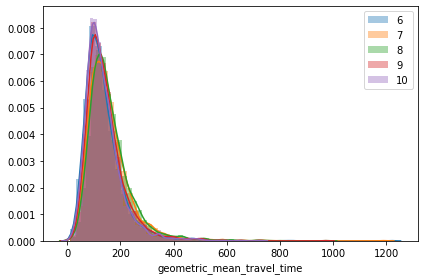

In [19]:
# verify distributions 
dists = [filtered_df[filtered_df['hod'] == hod]['geometric_mean_travel_time'] for hod in range(RUSH_HOUR_START, RUSH_HOUR_END + 1)]
for i, d in enumerate(dists): 
    ax = sn.distplot(d, label=str(i + RUSH_HOUR_START))
handles, labels = ax.get_legend_handles_labels() 
ax.legend(handles, labels); 
plt.tight_layout() 
plt.savefig("dist_plot.png", bbox_inches="tight")

In [20]:
# Run pairwise KS stests 
p_value = 1e-6
n_failed = 0 
print("Running KS 2 Sample Tests with p_value", p_value)
for i, hod1 in enumerate(range(RUSH_HOUR_START, RUSH_HOUR_END)): 
    for j, hod2 in enumerate(range(RUSH_HOUR_START + i + 1, RUSH_HOUR_END)):
        res = ks_2samp(dists[i], dists[j])
        print("Are hour", hod1, "and hour", hod2, "statistically the same?", res.pvalue < p_value)
        if not res.pvalue < p_value: 
            n_failed += 1 
            print("Failed with p value", res.pvalue)
if n_failed > 0: 
    print("Unable to generalize hours based on one hour.")

Running KS 2 Sample Tests with p_value 1e-06
Are hour 6 and hour 7 statistically the same? False
Failed with p value 1.0
Are hour 6 and hour 8 statistically the same? True
Are hour 6 and hour 9 statistically the same? True
Are hour 7 and hour 8 statistically the same? True
Are hour 7 and hour 9 statistically the same? False
Failed with p value 1.0
Are hour 8 and hour 9 statistically the same? True
Unable to generalize hours based on one hour.


In [28]:
# write to our format.
# template: node: [(x, y), [(edge, weight)]]
print("Converting Formats...")
graph_dict = {}
dist_dict = {}
for node in graph.nodes: 
    neighbors = graph.neighbors(node) 
    location = graph.nodes[node]['loc']
    # use geometric mean std for now 
    edges = []
    for neighbor in neighbors: 
        s = 0
        for hod in range(RUSH_HOUR_START, RUSH_HOUR_END + 1):
            s += graph[node][neighbor][hod]['gmean'] / (RUSH_HOUR_END - RUSH_HOUR_START + 1)
        edges.append((neighbor, s))
        dist_dict[(node, neighbor)] = deepcopy(graph[node][neighbor])
    graph_dict[node] = (location, tuple(edges))

Converting Formats...


In [29]:
print("Saving...")
with open("../pickles/graph.pypkle", 'wb') as f: 
    pickle.dump((graph_dict, dist_dict), f)
print("Done.")

Saving...
Done.
